
Processing Dataset: linear
Architecture: [2, 5, 3]
  Epoch 0 | Loss: 0.3076
  Epoch 100 | Loss: 0.0009

--- Evaluation Results ---
Train Accuracy: 100.00%
Validation Accuracy: 100.00%
Test Accuracy: 100.00%
Test Confusion Matrix:
[[43  0  0]
 [ 0 38  0]
 [ 0  0 39]]


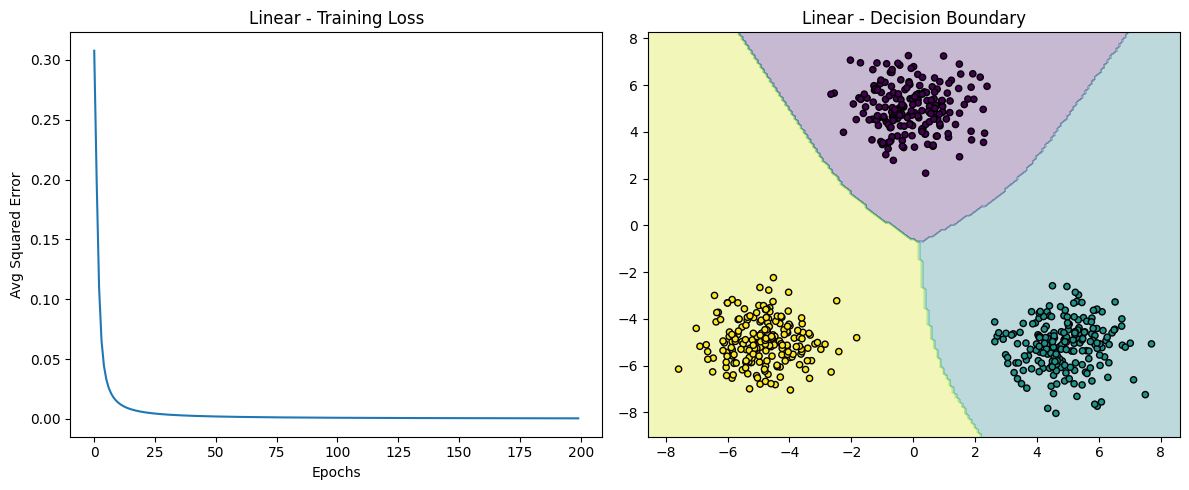


Processing Dataset: nonlinear
Architecture: [2, 8, 4, 2]
  Epoch 0 | Loss: 0.2512
  Epoch 100 | Loss: 0.2510
  Epoch 200 | Loss: 0.2510
  Epoch 300 | Loss: 0.2509
  Epoch 400 | Loss: 0.2489
  Epoch 500 | Loss: 0.1440
  Epoch 600 | Loss: 0.1022
  Epoch 700 | Loss: 0.0972
  Epoch 800 | Loss: 0.0956
  Epoch 900 | Loss: 0.0935

--- Evaluation Results ---
Train Accuracy: 89.17%
Validation Accuracy: 80.00%
Test Accuracy: 87.50%
Test Confusion Matrix:
[[40  0]
 [10 30]]


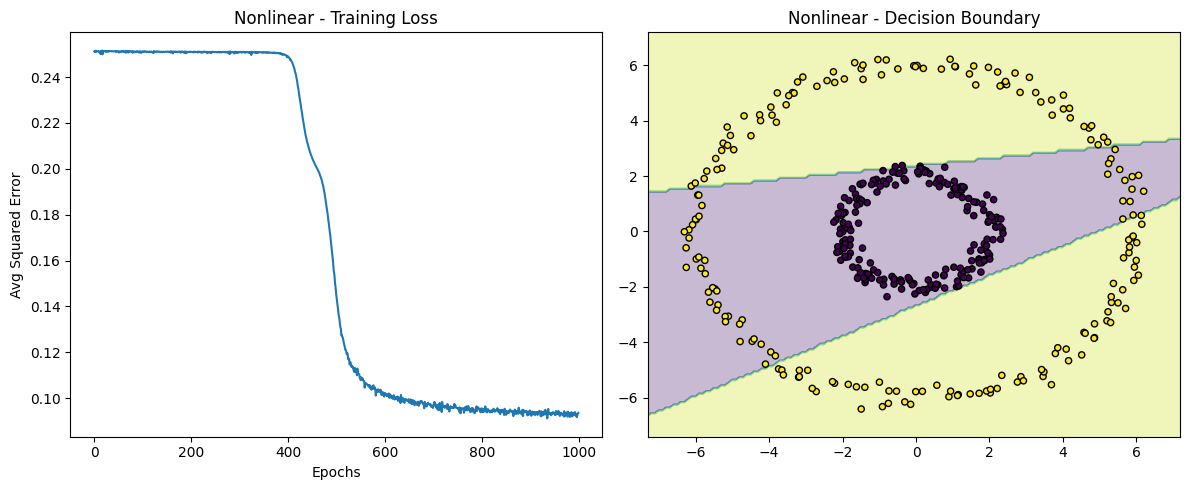

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Helper Functions (Data & Metrics)
# ==========================================

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y.astype(int)]

def generate_data(dataset_type):
    np.random.seed(0)
    samples_per_class = 200

    if dataset_type == "linear":
        # 3 Classes, Linearly Separable [cite: 69]
        X1 = np.random.randn(samples_per_class, 2) + np.array([0, 5])
        X2 = np.random.randn(samples_per_class, 2) + np.array([5, -5])
        X3 = np.random.randn(samples_per_class, 2) + np.array([-5, -5])
        X = np.vstack([X1, X2, X3])
        y = np.concatenate([np.zeros(samples_per_class), np.ones(samples_per_class), np.ones(samples_per_class)*2])
        return X, y, 3

    elif dataset_type == "nonlinear":
        # 2 Classes, Non-Linear (Concentric Circles) [cite: 70]
        theta = np.linspace(0, 2*np.pi, samples_per_class)
        r1 = 2
        r2 = 6
        X1 = np.c_[r1 * np.cos(theta), r1 * np.sin(theta)] + np.random.randn(samples_per_class, 2) * 0.2
        X2 = np.c_[r2 * np.cos(theta), r2 * np.sin(theta)] + np.random.randn(samples_per_class, 2) * 0.2
        X = np.vstack([X1, X2])
        y = np.concatenate([np.zeros(samples_per_class), np.ones(samples_per_class)])
        return X, y, 2

def split_data(X, y):
    # Requirement: 60% Train, 20% Val, 20% Test
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    split1 = int(0.6 * len(X))
    split2 = int(0.8 * len(X))

    train_idx = indices[:split1]
    val_idx = indices[split1:split2]
    test_idx = indices[split2:]

    return (X[train_idx], y[train_idx]), (X[val_idx], y[val_idx]), (X[test_idx], y[test_idx])

def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

def confusion_matrix(y_true, y_pred, num_classes):
    # Requirement: Confusion Matrix
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true.astype(int), y_pred.astype(int)):
        cm[t, p] += 1
    return cm

# ==========================================
# 2. Neural Network (FCNN) [cite: 74]
# ==========================================

class FCNN:
    def __init__(self, layer_sizes):
        self.weights = []
        self.biases = []
        self.layer_sizes = layer_sizes

        # Initialize weights
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.1
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        self.inputs = []
        self.activations = [X]
        a = X
        for i in range(len(self.weights)):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            self.inputs.append(z)
            a = sigmoid(z)
            self.activations.append(a)
        return a

    def backward(self, y_true, lr):
        # Requirement: Squared Error + SGD [cite: 77]
        y_pred = self.activations[-1]
        delta = (y_pred - y_true) * sigmoid_derivative(self.inputs[-1])
        deltas = [delta]

        for i in range(len(self.weights) - 2, -1, -1):
            delta = np.dot(deltas[-1], self.weights[i+1].T) * sigmoid_derivative(self.inputs[i])
            deltas.append(delta)
        deltas.reverse()

        for i in range(len(self.weights)):
            self.weights[i] -= lr * np.dot(self.activations[i].T, deltas[i])
            self.biases[i] -= lr * np.sum(deltas[i], axis=0, keepdims=True)

    def train(self, X, y, epochs=1000, lr=0.01):
        loss_history = []
        indices = np.arange(len(X))

        for epoch in range(epochs):
            np.random.shuffle(indices)
            epoch_loss = 0

            # SGD: Batch Size = 1 [cite: 77]
            for i in indices:
                x_sample = X[i:i+1]
                y_sample = y[i:i+1]
                self.forward(x_sample)
                self.backward(y_sample, lr)
                epoch_loss += 0.5 * np.sum((self.activations[-1] - y_sample)**2)

            loss_history.append(epoch_loss / len(X))
            if epoch % 100 == 0:
                print(f"  Epoch {epoch} | Loss: {loss_history[-1]:.4f}")

        return loss_history

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

# ==========================================
# 3. Main Execution & Visuals
# ==========================================

def run_task3():
    datasets = ["linear", "nonlinear"]

    for ds_type in datasets:
        print(f"\n{'='*40}\nProcessing Dataset: {ds_type}\n{'='*40}")

        # 1. Prepare Data
        X, y, n_classes = generate_data(ds_type)
        (X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y)

        # One-hot encode training target
        y_train_enc = one_hot_encode(y_train, n_classes)

        # 2. Define Architecture [cite: 75]
        # Linear: 1 Hidden Layer | Non-Linear: 2 Hidden Layers
        if ds_type == "linear":
            layers = [2, 5, 3] # Input=2, Hidden=5, Output=3
            epochs = 200
            lr = 0.05
        else:
            layers = [2, 8, 4, 2] # Input=2, Hidden1=8, Hidden2=4, Output=2
            epochs = 1000
            lr = 0.05

        print(f"Architecture: {layers}")
        model = FCNN(layers)

        # 3. Train
        loss_hist = model.train(X_train, y_train_enc, epochs=epochs, lr=lr)

        # 4. Evaluation
        print("\n--- Evaluation Results ---")
        for name, X_set, y_set in [("Train", X_train, y_train), ("Validation", X_val, y_val), ("Test", X_test, y_test)]:
            preds = model.predict(X_set)
            acc = accuracy_score(y_set, preds)
            print(f"{name} Accuracy: {acc*100:.2f}%")
            if name == "Test":
                print(f"Test Confusion Matrix:\n{confusion_matrix(y_set, preds, n_classes)}")

        # 5. Plotting Results [cite: 79, 80]
        plt.figure(figsize=(12, 5))

        # Plot A: Loss Curve
        plt.subplot(1, 2, 1)
        plt.plot(loss_hist)
        plt.title(f"{ds_type.capitalize()} - Training Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Avg Squared Error")

        # Plot B: Decision Boundary
        plt.subplot(1, 2, 2)
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
        grid = np.c_[xx.ravel(), yy.ravel()]
        preds = model.predict(grid).reshape(xx.shape)

        plt.contourf(xx, yy, preds, alpha=0.3, cmap='viridis')
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='viridis', s=20)
        plt.title(f"{ds_type.capitalize()} - Decision Boundary")

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    run_task3()